# Pneumonia Detection using Convolutional Neural Networks

## Objective 

The primary goal of this project is to build a Convolutional Neural Network (CNN) model to classify chest X-ray images into two categories: Pneumonia and Normal.

## Dataset

**Source** : Kaggle (https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)

**Content** : The dataset includes labeled X-ray images for both pneumonia and normal cases.

**Structure** :

    Chest_Xrays

        Training Set
            Normal
            Pneumonia

        Validation Set
            Normal
            Pneumonia

        Test Set
            Normal
            Pneumonia

### Explore the Dataset

In [1]:
import os

# Define base directory
base_dir = r'C:\Users\mouad\chest_xray'


# Define subdirectories for train, validation, and test
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Count the number of images in each category
def count_images(directory):
    normal_count = len(os.listdir(os.path.join(directory, "NORMAL")))
    pneumonia_count = len(os.listdir(os.path.join(directory, "PNEUMONIA")))
    print(f"Normal: {normal_count}, Pneumonia: {pneumonia_count}")

# Inspect datasets
print("Training set:")
count_images(train_dir)
print("\nValidation set:")
count_images(val_dir)
print("\nTest set:")
count_images(test_dir)


Training set:
Normal: 1341, Pneumonia: 3875

Validation set:
Normal: 92, Pneumonia: 92

Test set:
Normal: 150, Pneumonia: 306


## Data Preprocessing 

We will preprocess the dataset by resizing all images to a uniform size of 224x224. Then, we will use TensorFlow's **ImageDataGenerator** to load the data. The ImageDataGenerator class normalizes pixel values to the range [0,1] for faster model convergence and applies necessary image transformations to enrich the data and prevent overfitting.

In [2]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt

# Set up image generators for loading and augmenting the images
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values to [0, 1]
    rotation_range=40,     # Random rotations
    width_shift_range=0.2, # Horizontal shift
    height_shift_range=0.2, # Vertical shift
    shear_range=0.2,       # Shear transformations
    zoom_range=0.2,        # Zoom in/out
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'    # Fill missing pixels
)

validation_datagen = ImageDataGenerator(rescale=1./255) # Only rescaling for validation and test sets

# Define base directory
base_dir = r'C:\Users\mouad\chest_xray'

# Define subdirectories for train, validation, and test
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

- **train_datagen**:

    *rescale*=1./255: Normalizes pixel values to the range [0, 1].
    
    *rotation_range* = 40: Randomly rotates images by up to 40 degrees.
    
    *width_shift_range* and *height_shift_range*: Randomly shifts images horizontally and vertically.
    
    *shear_range*: Applies shear transformations.
    
    *zoom_range*: Randomly zooms in or out on images.
    
    *horizontal_flip* = True: Randomly flips images horizontally.
    
    *fill_mode* = 'nearest': Fills missing pixels after transformations using the nearest pixel value.

- **validation_datagen**:
    Only rescales pixel values (no augmentation) since data augmentation is typically not applied to validation/test data.

In [3]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Resize images to fit the model input
    batch_size=32,
    class_mode='binary',     # For binary classification (Normal vs Pneumonia)
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 184 images belonging to 2 classes.
Found 456 images belonging to 2 classes.


### Check the loading of data

To ensure everything works properly, we can visualize some images from the train_generator:

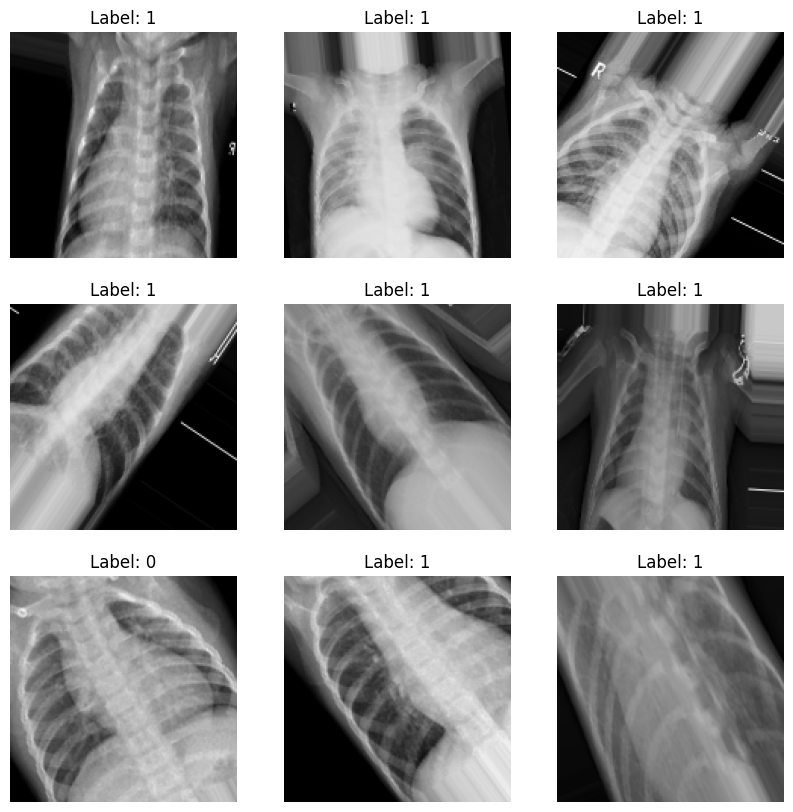

In [4]:
import matplotlib.pyplot as plt

# Get a batch of images and labels
images, labels = next(train_generator)

# Plot the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {int(labels[i])}")  # Label will be 0 or 1
    plt.axis("off")
plt.show()


### Extract Images and Labels from the Generator

In [5]:
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter

# Step 1: Extract all images and labels from the train_generator
X_train = []
y_train = []

for i in range(len(train_generator)):
    images, labels = train_generator[i]
    X_train.append(images)
    y_train.append(labels)

# Convert lists to NumPy arrays
X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

# Check the shape of the training data
print("X_train shape:", X_train.shape)  # Should be (num_samples, height, width, channels)
print("y_train shape:", y_train.shape)  # Should be (num_samples,)

# Step 2: Extract all images and labels from the validation_generator
X_val = []
y_val = []

for i in range(len(validation_generator)):
    images, labels = validation_generator[i]
    X_val.append(images)
    y_val.append(labels)

# Convert lists to NumPy arrays
X_val = np.concatenate(X_val)
y_val = np.concatenate(y_val)

# Check the shape of the validation data
print("X_val shape:", X_val.shape)  # Should be (num_samples, height, width, channels)
print("y_val shape:", y_val.shape)  # Should be (num_samples,)

# Step 3: Move some images from the training set to the validation set
# Set the random seed for reproducibility
np.random.seed(42)

# Number of images to move (e.g., 257 to increase validation set to 437)
num_images_to_move = 257

# Randomly select indices of images to move
indices_to_move = np.random.choice(len(X_train), num_images_to_move, replace=False)

# Move the selected images and labels from training to validation
X_val = np.concatenate([X_val, X_train[indices_to_move]])
y_val = np.concatenate([y_val, y_train[indices_to_move]])

# Remove the moved images from the training set
X_train = np.delete(X_train, indices_to_move, axis=0)
y_train = np.delete(y_train, indices_to_move, axis=0)

# Check the new sizes
print("New X_train shape:", X_train.shape)
print("New y_train shape:", y_train.shape)
print("New X_val shape:", X_val.shape)
print("New y_val shape:", y_val.shape)

X_train shape: (5216, 150, 150, 3)
y_train shape: (5216,)
X_val shape: (184, 150, 150, 3)
y_val shape: (184,)
New X_train shape: (4959, 150, 150, 3)
New y_train shape: (4959,)
New X_val shape: (441, 150, 150, 3)
New y_val shape: (441,)


### Flatten the Images for SMOTE


In [6]:
# Flatten the images
num_samples, height, width, channels = X_train.shape
X_train_flat = X_train.reshape(num_samples, -1)  # Shape: (num_samples, height * width * channels)

### Apply SMOTE

In [7]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_flat_resampled, y_train_resampled = smote.fit_resample(X_train_flat, y_train)

# Reshape the flattened images back to their original shape
X_train_resampled = X_train_flat_resampled.reshape(-1, height, width, channels)

# Check the new class distribution
from collections import Counter
print("Original class distribution:", Counter(y_train))
print("Resampled class distribution:", Counter(y_train_resampled))

Original class distribution: Counter({np.float32(1.0): 3684, np.float32(0.0): 1275})
Resampled class distribution: Counter({np.float32(1.0): 3684, np.float32(0.0): 3684})
